<a href="https://colab.research.google.com/github/fluderm/Model-compression/blob/main/Compression_techniques_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SVD vs Pruing vs Quantization vs Distillation Learning:

**Low-rank heuristics:**
 
Let us for simplicity consider the matrix multiplication of $A \cdot B$ with $A,B \in \mathbb{R}^{m\times m}$. Then, if we rank-reduce by a factor of $r\in (0,1)$, i.e. we approximate $A \sim \sum_{i=1}^{m r} s_i \mathbf{u_i} \mathbf{v_i}^\mathrm{T}$, we expect a time complexity for the matrix multiplication of order $\sim O(rm^3)$. (There are nowadays faster matrix multiplication algorithms of order $\sim O(m^{2.3})$, but for the current heuristics we shall neglect this.) Thus, by using SVD, we get a theoretical time complexity reduction of $\sim 1/r$. With regards to memory usage, naively (there might be optimizations), we would need to use $\sim O(2 m^2 r)$ versus $\sim O(m^2)$ space complexity. Thus, by appropriately chosing $r < 1/2$, saving potentially a lot of memory space.

Therefore, on theoretical grounds, low-rank approximations are able to achieve significant size and inference and training latency reductions. None of the improvements are hardware or implementation dependent and should work on general grounds (we shall see this in the CIFAR10 example below).

I would expect that using fine-tuning of $r$ and potential retraining (see below) the low-rank method works well for arbitrary tasks and by employing it, one can expect a relatively standard boost in speed and memory usage.
 
**Pruning:**
 
Pruning is the method of removing connections between neurons (or entire neurons) from a network. This is achieved by setting elements of the weight matrices to zero. These elements can either be unstructured (i.e. remove individual weights) or structured (i.e. remove entire channels -- or columns of weight matrices). In either case, the goal is to create sparse weight matrices, whose memory usage and matrix matrix multiplications can be optimized, leading to overall less memory consumption and faster execution speeds.
 
On theoretical grounds (depending on the algorithm), sparse matrix multiplication for a matrices $A,B \in \mathbb{R}^{m\times m}$ with $\sim k$ nonzero elements can be done in roughly $O(m k)$ time (this estimation is based on a naive straight-forward algorithm). Thus, assuming that we prune a potential weight matrix by a factor of 95%, the time complexity of the pruned multiplication would be $\sim O(m^3/1000)$. Given these assumptions, we can expect a factor of $\sim 1000$ speedup in our inference speed, while retaining decent performance. Similarly, for space complexity, with the same assumptions we expect an improvement by a factor of $1000$, namely $O(2 m^2) \to O(2 m^2/1000)$.
 
On fundamental grounds, it is unclear to me how well pruning will generalize to different tasks. While it seems that it retains good accuracy in the CIFAR10 example, there is no guarantee that it does so if we start with a different model architecture or a different dataset/task. In particular, I am curious as to whether it performs well in regression tasks rather than classification. Similarly, one might simply do distillation learning (see below), or use a more efficient architecture.
 
**Quantization:**
 
The idea behind the compression method of quantization is that instead of reducing the number of non-zero weights, we reduce the "size" of the weights by quantizing them to a smaller, discrete set of potential values, while still retaining as much information as possible. As a consequence, each weight will take up less memory space, thus decreasing the overall memory usage as well as inference speed (the computation $5+3$ is clearly faster than $5.0000032+3.23142959812$). The performance boost from quantization is crucially dependent on hardware and the particular implementation. While there might be general guidelines, it seems that a case-by-case analysis and explicit empirical implementation is more suitable.

**Distillation learning:**

See below for my (naive) implementation of distillation learning in the CIFAR10 example. It seems to work extremely well, retaining good accuracy while speeding up inference by a factor substantially surpassing the low-rank implementation.

**Conclusions:**

Overall, it seems that each of these methods has its own merits, and there is a large amount of literature combining and improving upon them to great effect. Overall, naive low-rank approximations are quite easily implemented (see below), while both quantization and pruning require either improvements in algorithms (sparse matrix multiplication) or hardware optimizations.




# Setup CIFAR model

In [1]:
!pip install dm-haiku optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 4.9 MB/s eta 0:00:00


In [2]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




In [3]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
DATA_MEANS=[0.4913996786152028,0.4821584083946074,0.4465309144454644]

CIFAR10_STD = (0.2023, 0.1994, 0.2010)
DATA_STD=[0.24703223246328238,0.2434851280000556,0.26158784172796423]


# loads the architecture of the NN in haiku.
def net_fn(batch: Batch) -> jnp.ndarray:

  x = normalize(batch[0])
  
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

# Function that loads the datasets in batches. 
# The output is an iterator over the batches.
def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  
  ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Loss function for our NN; here we choose a L_2 regularized version of the
# categorical log-likelihood (i.e. the softmax loss)
def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  
  x, y = batch
  logits = net.apply(params, batch)
  labels = jax.nn.one_hot(y, 10)

  l2_loss = 0.5*sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
  weighted_l2_loss = 0.5 * l2_loss
  
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))/labels.shape[0]
  
  return softmax_xent + (1e-4 * l2_loss)

@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  predictions = net.apply(params, batch)

  accuracy= jnp.mean(jnp.argmax(predictions, axis=-1) == batch[1])
  return accuracy

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  return optax.incremental_update(params, avg_params, step_size=0.001)

def normalize(images):
  x = images.astype(jnp.uint8) / 255.
  x -= np.asarray(DATA_MEANS)
  x /= np.asarray(DATA_STD) #(std)

  return x

## Train base model

In [4]:
net = hk.without_apply_rng(hk.transform(net_fn))

opt = optax.adam(1e-3)

train = load_dataset("train", is_training=True, batch_size=1000)
validation = load_dataset("train", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)

params = avg_params = net.init(jax.random.PRNGKey(42), next(train))
opt_state = opt.init(params)

best_test_accuracy=0

for step in range(5001):
  if step % 100 == 0:
    val_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    
    val_accuracy, test_accuracy = jax.device_get(
        (val_accuracy, test_accuracy))

    # save best parameters:
    if test_accuracy>best_test_accuracy:
      best_params=avg_params
      best_test_accuracy=test_accuracy

    if step %1000==0:  
      print(f"[Step {step}] Validation / Test accuracy: "
            f"{val_accuracy:.3f} / {test_accuracy:.3f}.")
    
  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteV2AA1S/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteV2AA1S/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


[Step 0] Validation / Test accuracy: 0.103 / 0.103.
[Step 1000] Validation / Test accuracy: 0.592 / 0.486.
[Step 2000] Validation / Test accuracy: 0.987 / 0.633.
[Step 3000] Validation / Test accuracy: 0.225 / 0.216.
[Step 4000] Validation / Test accuracy: 0.676 / 0.496.
[Step 5000] Validation / Test accuracy: 0.981 / 0.556.


### Save/Load model

In [5]:
params=best_params

In [6]:
val_accuracy = compute_accuracy(params, next(validation))
test_accuracy = compute_accuracy(params, next(test))

val_accuracy, test_accuracy = jax.device_get(
    (val_accuracy, test_accuracy))
print(f"Best params: Validation / Test accuracy: "
      f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

Best params: Validation / Test accuracy: 0.999 / 0.650.


#### Save

In [7]:
import pickle

f = open("params.pkl","wb")
pickle.dump(params,f)
f.close()

#### Load

In [ ]:
import pickle

train = load_dataset("train", is_training=True, batch_size=1000)
validation = load_dataset("train", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)

net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate
opt = optax.adam(1e-3)

train = load_dataset("train", is_training=True, batch_size=1000)
validation = load_dataset("train", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)


with open('params.pkl', 'rb') as handle:
    params = pickle.load(handle)

val_accuracy = compute_accuracy(params, next(validation))
test_accuracy = compute_accuracy(params, next(test))

val_accuracy, test_accuracy = jax.device_get(
    (val_accuracy, test_accuracy))
print(f"Best params: Validation / Test accuracy: "
      f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

## Compute Latency time

In [8]:
import torch

@jax.jit
def predict(x, para):
  return net.apply(para, x)

starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

def latency_time(params, batch, n_samples):

  timings=np.zeros((n_samples,))
  #warm-up
  for _ in range(10):
    _ = predict(batch,params)

  with torch.no_grad():
    for rep in range(n_samples):
      starter.record()
      _ = predict(batch,params)
      ender.record()

      torch.cuda.synchronize()
      curr_time = starter.elapsed_time(ender)
      timings[rep] = curr_time
  
  return timings

In [9]:
def compute_eval_metrics(params, batch, n_samples):
  duration_list=latency_time(params, batch, n_samples)

  predictions=predict(batch,params)
  accuracy_list=jax.device_get((jnp.mean(jnp.argmax(predictions, axis=-1) == batch[1])))
  
  return accuracy_list,duration_list

# 1. Naive SVD factorized space models


## Matrix Multiplication Toy Model:

 The toy example below is also instructive for the next part, where we work in factorized space and thus are expected to see a performance boost (and we can even predict that it should be linear in rank reduction).



In [ ]:
def mat_mult_timing(M1_tuple,n_samples):

  timings=np.zeros((n_samples,))
  #warm-up
  for _ in range(10):
    if len(M1_tuple)==3:
      _ = M1_tuple[0]@M1_tuple[1]@M1_tuple[2]
    else:
      _ = M1_tuple[0]@M1_tuple[1]

  with torch.no_grad():
    for rep in range(n_samples):
      if len(M1_tuple)==3:
        starter.record()
        _ = M1_tuple[0]@(M1_tuple[1]@M1_tuple[2])
        ender.record()
      else:
        starter.record()
        _ = M1_tuple[0]@M1_tuple[1]
        ender.record()

      torch.cuda.synchronize()
      curr_time = starter.elapsed_time(ender)
      timings[rep] = curr_time
  
  return timings

A=np.random.random((3000,1000))
U,S,V=np.linalg.svd(A)
B=np.random.random((1000,1000))

toy_example_timings=[]
for rkfrac in np.arange(1.0, 0.0, -0.1):
  B_rank=int(rkfrac*min(B.shape))
  uu=U[:, :B_rank] * S[:B_rank]
  vv=V[:B_rank, :]
  A_tilde=uu@vv

  timing_with_factorization=mat_mult_timing((uu,vv,B),50)
  timing_without_factorization=mat_mult_timing((A_tilde,B),50)

  toy_example_timings.append((rkfrac,np.mean(timing_with_factorization),np.std(timing_with_factorization),
                       np.mean(timing_without_factorization),np.std(timing_without_factorization)))
  #print(toy_example_timings[-1])

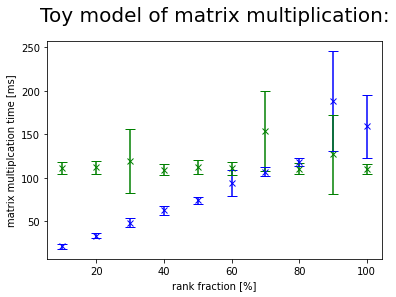

In [ ]:
plt.errorbar(100*np.array(toy_example_timings)[:,0],
             np.array(toy_example_timings)[:,1],
             np.array(toy_example_timings)[:,2],linestyle='None',marker='x',color='blue',capsize=5)

plt.errorbar(100*np.array(toy_example_timings)[:,0],
             np.array(toy_example_timings)[:,3],
             np.array(toy_example_timings)[:,4],linestyle='None',marker='x',color='green',capsize=5)

plt.title('Toy model of matrix multiplication:', fontsize=20, pad='20.0')
plt.xlabel('rank fraction [%]')
plt.ylabel('matrix multiplcation time [ms]')

plt.show()

The above plot empirically shows that by precomputing $A \cdot B = \left(\sum_{i=1}^{f} u_i s_i v^{\mathrm{T}}_i\right) \cdot B$, rank reduction has no effect on the matrix multiplication speed (we will always perform $O(nkl)$ operations, where $A \in \mathbb{R}^{n\times k}$ and $B \in \mathbb{R}^{k\times l}$). Here, $f$ is the rank reduction coefficient $r$ times $\mathrm{min}(n,k)$, \emph{i.e.} $f=r\cdot \mathrm{min}(n,k)$.
 
However, if we evaluate $A \cdot B = \sum_{i=1}^{f} (u_i s_i) v^{\mathrm{T}}_i \cdot B$, we perform $O\left(n k f+ k l f\right)$. Thus, depending on the size of $f$ (or $r$) one can expect potential speedups in the matrix multiplication (and especially upon chaining together many such operations as is done in a neural net). Notice that given this heuristic, one might expect that the two toy models intersect at $r\sim$ 50% rank fraction, which is approximately reproduced in the empirical plot above. I believe the deviation from exactly 50% is due to NumPy using some speedups that reduce the asymptotic time complexity of matrix multiplication to something slightly smaller than $O(nlk)$.
 
Finally, we notice that the number of parameters we ought to store for A reduces from $O(nk)$ to $O((m+n)k)$, thus reducing the space complexity of our neural network (potentially) significantly.



## Actual rank-reduced NN:

In [ ]:
weight_to_SVD={}

def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  # perform SVD, and if already performed for these weights, use the results
  # stored in the weight_to_SVD-dictionary
  if layer in weight_to_SVD:
    U,S,V=weight_to_SVD[layer]
  else:
    U,S,V=jnp.linalg.svd(weight)
    weight_to_SVD[layer]=(U,S,V)
  
  # create the matrices u and v given the rank_fraction
  size=int(rank_fraction*min(weight.shape))
  u = U[:, :size] * S[:size]
  v = V[:size, :]
  
  return u, v

In [ ]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:
  
  x = normalize(batch[0])
  total_input_dim = np.prod(x.shape[1:])

  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,      
      hk.Linear(int(rank * 1000), with_bias=False), 
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []
ranks_and_mem = []

for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial)) 
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at " f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']
  
  test_batch=next(test)
  test_accuracy, duration = compute_eval_metrics(low_rank_params,test_batch, 50)

  # save inference times, accuracies and memory usage
  ranks_and_times.append((rank_fraction, np.mean(duration), np.std(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  ranks_and_mem.append(sum(p.nbytes for p in jax.tree_util.tree_leaves(low_rank_params))/121848904)

  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(duration):.4f}.")
  print(f"Memory usage vs original model: "
          f"{ranks_and_mem[-1]:.2f}")

## Conclusions:

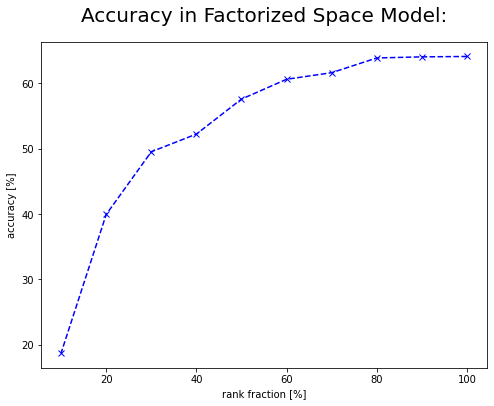

In [ ]:
# For completion added accuracy and memory plots as well

plt.figure(figsize=(8, 6))

plt.plot(100*np.array(ranks_and_accuracies)[:,0],
          100*np.array(ranks_and_accuracies)[:,1], linestyle='--', marker='x', color='b')

plt.title('Accuracy in Factorized Space Model:', fontsize=20, pad='20.0')
plt.xlabel('rank fraction [%]')
plt.ylabel('accuracy [%]')

plt.show()

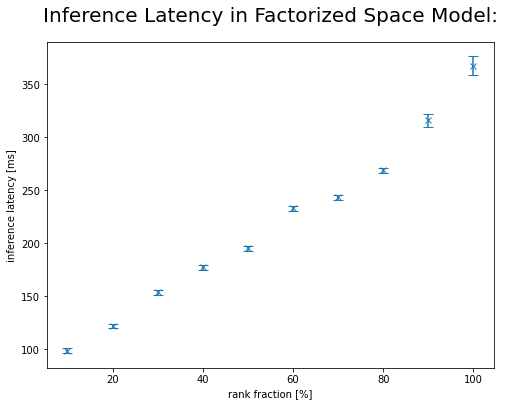

In [ ]:
# Inference latency plot

plt.figure(figsize=(8, 6))

plt.errorbar(100*np.array(ranks_and_times)[:,0],
             np.array(ranks_and_times)[:,1],
             np.array(ranks_and_times)[:,2],linestyle='None',marker='x',capsize=5)
plt.title('Inference Latency in Factorized Space Model:', fontsize=20, pad='20.0')
plt.xlabel('rank fraction [%]')
plt.ylabel('inference latency [ms]')

plt.show()

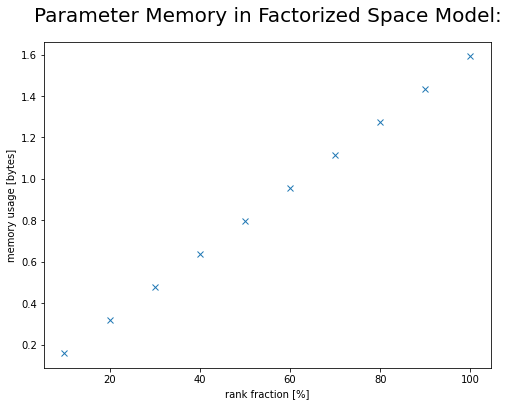

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(100*np.array(ranks_and_times)[:,0],
             np.array(ranks_and_mem)[:],linestyle='None',marker='x')

plt.title('Parameter Memory in Factorized Space Model:', fontsize=20, pad='20.0')
plt.xlabel('rank fraction [%]')
plt.ylabel('memory usage [bytes]')

plt.show()

As expected (see above), we see a inference latency time reduction **linear** in the percentage rank of the weight matrices. 

It is also noteworthy that the inference speed of the original non-factorized space model sits between 50% and 60% in the factorized space version, again confirming the naive heuristics as well as the empirical matrix multiplication toy model.
 
Lastly, we found that the memory usage of the parameters reduces by a factor linear in the percentage rank of the weight matrices (also confirming the space complexity heuristics).






---



# 2. Retrain SVD factorized space models

This will improve accuracy, while keeping latency low. As a proof of concept we retrain the smaller models below starting from the rank-reduced parameters.

In [ ]:
#net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial))

rank_fraction_and_data=[]
for rank_fraction in np.arange(0.5, 0.0, -0.1):

  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial)) 
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at " f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']

    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']

  #Training:
  opt = optax.adam(1e-3)
  opt_state = opt.init(low_rank_params)
  low_rank_avg_params=low_rank_params
  
  acc_before_retraining=compute_accuracy(low_rank_params, next(test))

  low_rank_best_test_accuracy=0
  for step in range(2001):
    if step % 100 == 0:
      low_rank_val_accuracy = compute_accuracy(low_rank_avg_params, next(validation))
      low_rank_test_accuracy = compute_accuracy(low_rank_avg_params, next(test))
      
      low_rank_val_accuracy, low_rank_test_accuracy = jax.device_get(
          (low_rank_val_accuracy, low_rank_test_accuracy))

      if low_rank_test_accuracy>low_rank_best_test_accuracy:
        low_rank_best_params=low_rank_avg_params
        low_rank_best_test_accuracy=low_rank_test_accuracy

      if step %1000==0:  
        print(f"[Step {step}] Validation / Test accuracy: "
              f"{low_rank_val_accuracy:.3f} / {low_rank_test_accuracy:.3f}.")
      
    low_rank_params, opt_state = update(low_rank_params, opt_state, next(train))
    low_rank_avg_params = ema_update(low_rank_params,low_rank_avg_params)
  
  lat_low_rank=latency_time(low_rank_best_params, next(test), 50)
  acc_low_rank=compute_accuracy(low_rank_best_params, next(test))

  #save data:
  rank_fraction_and_data.append([rank_fraction,np.mean(lat_low_rank),np.std(lat_low_rank),acc_low_rank,acc_before_retraining])

  #print summary:
  print(f"[Rank Fraction = {rank_fraction:.2f}] Latency (mean) = {np.mean(lat_low_rank):.2f},"
      f"Latency (std) = {np.std(lat_low_rank):.2f},"
      f"Accuracy (before) = {acc_before_retraining:.2f},"
      f"Accuracy (after) = {acc_low_rank:.2f}.")

Evaluating the model at 0.50
[Step 0] Validation / Test accuracy: 0.805 / 0.563.
[Step 1000] Validation / Test accuracy: 0.998 / 0.644.
[Step 2000] Validation / Test accuracy: 1.000 / 0.654.
[Rank Fraction = 0.50] Latency (mean) = 184.18,Latency (std) = 1.81,Accuracy (before) = 0.56,Accuracy (after) = 0.66.
Evaluating the model at 0.40
[Step 0] Validation / Test accuracy: 0.711 / 0.522.
[Step 1000] Validation / Test accuracy: 0.975 / 0.620.
[Step 2000] Validation / Test accuracy: 1.000 / 0.651.
[Rank Fraction = 0.40] Latency (mean) = 165.42,Latency (std) = 1.53,Accuracy (before) = 0.52,Accuracy (after) = 0.65.
Evaluating the model at 0.30
[Step 0] Validation / Test accuracy: 0.651 / 0.488.
[Step 1000] Validation / Test accuracy: 0.804 / 0.585.
[Step 2000] Validation / Test accuracy: 0.420 / 0.315.
[Rank Fraction = 0.30] Latency (mean) = 141.23,Latency (std) = 0.75,Accuracy (before) = 0.49,Accuracy (after) = 0.64.
Evaluating the model at 0.20
[Step 0] Validation / Test accuracy: 0.521 /

## Conclusions:

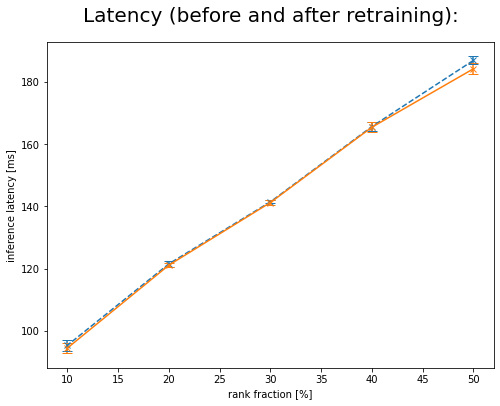

In [ ]:
plt.figure(figsize=(8, 6))

plt.errorbar(100*np.array(ranks_and_times)[5:,0],
             np.array(ranks_and_times)[5:,1],
             np.array(ranks_and_times)[5:,2],linestyle='--',marker='x',capsize=5)

plt.errorbar(100*np.array(rank_fraction_and_data)[:,0],
             np.array(rank_fraction_and_data)[:,1],
             np.array(rank_fraction_and_data)[:,2],linestyle='-',marker='x',capsize=5)

plt.title('Latency (before and after retraining):', fontsize=20, pad='20.0')
plt.xlabel('rank fraction [%]')
plt.ylabel('inference latency [ms]')

plt.show()

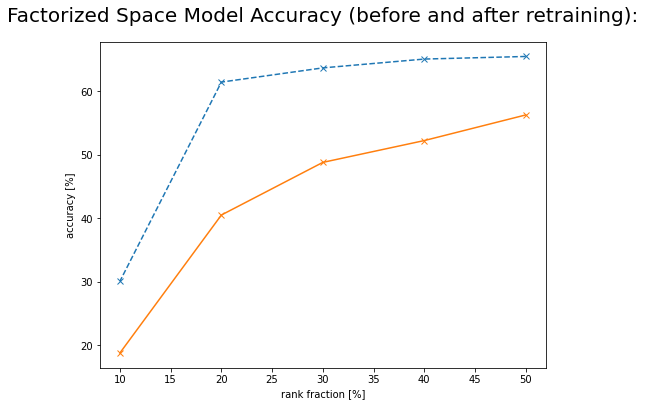

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(100*np.array(rank_fraction_and_data)[:,0],
        100*np.array(rank_fraction_and_data)[:,3],linestyle='--',marker='x')

plt.plot(100*np.array(rank_fraction_and_data)[:,0],
        100*np.array(rank_fraction_and_data)[:,4],marker='x')

plt.title('Factorized Space Model Accuracy (before and after retraining):', fontsize=20, pad='20.0')
plt.xlabel('rank fraction [%]')
plt.ylabel('accuracy [%]')

plt.show()

**Comments:** This simple experiment suggests that retraining the smaller models can lead to a potentially marked improvement in accuracy while keeping the inference latency constant.



---



# 3. Knowledge Distillation

We train a smaller (and faster) "student model" to match the output of the original (non-factorized space) "teacher model". We use the same architecture but simply reduce the number of nodes in the linear layers by a "layer reduction factor" = (10,20,50,100,200,500,1000). This decreases latency substantially while keeping some amount of accuracy. As a matter of fact it seems we hit a bottleneck for latency while still acheiving very high accuracy.
 
 
I choose SGD to minimize the mean squared error (MSE) between the student predictions for the 10 classes and the "teacher model" output (plus an L2 regularization term). I know that in general a temperature-modified softmax function is used in distillation learning, but MSE loss works very well in the current example, seemed quite natrual to me and does not require an additional hyperparameter (such as temperature).
 


## Basic functions for student training

In [ ]:
def student_compute_loss(stud_parameters: hk.Params, batch: Batch) -> jnp.ndarray:
  student_predictions = student_net.apply(stud_parameters, batch)
  predictions = net_predict(batch)

  l2_loss = 0.5*sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(stud_parameters))
  
  square_loss = jnp.sum(jnp.square(student_predictions-predictions))/(10*batch[1].shape[0])

  return square_loss + (1e-4 * l2_loss)

#@jax.jit
def student_compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  stud_predictions = student_net.apply(params, batch)

  stud_accuracy = jnp.mean(jnp.argmax(stud_predictions, axis=-1) == batch[1])
  return stud_accuracy

@jax.jit
def student_update(
    stud_parameters: hk.Params,
    stud_opt_state: optax.OptState,
    stud_batch: Batch) -> Tuple[hk.Params, optax.OptState]:
  stud_grads = jax.grad(student_compute_loss)(stud_parameters, stud_batch)
  stud_updates, stud_opt_state = opt.update(stud_grads, stud_opt_state)
  stud_new_params = optax.apply_updates(stud_parameters, stud_updates)
  return stud_new_params, stud_opt_state

@jax.jit
def student_ema_update(stud_params, stud_avg_params):
  return optax.incremental_update(stud_params, stud_avg_params, step_size=0.001)

def student_normalize(stud_images):
  x = stud_images.astype(jnp.uint8) / 255.
  x -= DATA_MEANS
  x /= DATA_STD
  return x

@jax.jit
def net_predict(x):
  return net.apply(params, x)

## Student Timing

In [ ]:
@jax.jit
def student_predict(x, para):
  return student_net.apply(para, x)

starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

def student_latency_time(parameters, batch, n_samples):

  timings=np.zeros((n_samples,))
  #warm-up
  for _ in range(10):
    _ = student_predict(batch,parameters)

  with torch.no_grad():
    for rep in range(n_samples):
      starter.record()
      _ = student_predict(batch,parameters)
      ender.record()

      torch.cuda.synchronize()
      curr_time = starter.elapsed_time(ender)
      timings[rep] = curr_time
  
  return timings

## Training

In [ ]:
layer_reduction_data=[]

for layer_reduction in [10,20,50,100]:
  print('\033[1m' + 
        f"Student model with linear layer reduced by factor 1/" f"{layer_reduction}:"+
        '\033[0m')

  def student_net_fn(batch: Batch) -> jnp.ndarray:

    x = normalize(batch[0])
    
    stud_net = hk.Sequential([
        hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
        jax.nn.relu,
        hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
        hk.Flatten(),
        hk.Linear(3000//layer_reduction), jax.nn.relu,
        hk.Linear(2000//layer_reduction), jax.nn.relu,
        hk.Linear(2000//layer_reduction), jax.nn.relu,
        hk.Linear(1000//layer_reduction), jax.nn.relu,
        hk.Linear(10),
    ])
    return stud_net(x)

  student_net = hk.without_apply_rng(hk.transform(student_net_fn))
  opt = optax.adam(1e-3)

  student_params = student_avg_params = student_net.init(jax.random.PRNGKey(42), next(train))
  student_opt_state = opt.init(student_params)

  student_best_test_accuracy=0

  for step in range(5001):
    if step % 100 == 0:
      student_val_accuracy = student_compute_accuracy(student_avg_params, next(validation))
      student_test_accuracy = student_compute_accuracy(student_avg_params, next(test))
      
      student_val_accuracy, student_test_accuracy = jax.device_get(
          (student_val_accuracy, student_test_accuracy))

      if student_test_accuracy>student_best_test_accuracy:
        student_best_params=student_avg_params
        student_best_test_accuracy=student_test_accuracy

      if step %1000==0:  
        print(f"[Step {step}] Validation / Test accuracy: "
              f"{student_val_accuracy:.3f} / {student_test_accuracy:.3f}.")
      
    student_params, student_opt_state = student_update(student_params, student_opt_state, next(train))
    student_avg_params = student_ema_update(student_params, student_avg_params)

  student_reduction_latency=student_latency_time(student_best_params, next(test),100)

  layer_reduction_data.append([layer_reduction,np.mean(student_reduction_latency),
                               np.std(student_reduction_latency),student_best_test_accuracy,])
  #print summary:
  print(f"[Layer Reduction = {layer_reduction}] Latency (mean) = {layer_reduction_data[-1][1]:.2f},"
      f" Latency (std) = {layer_reduction_data[-1][2]:.2f},"
      f" Accuracy = {layer_reduction_data[-1][3]:.2f}.")

Student model with linear layer reduced by factor 1/10:


/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


[Step 0] Validation / Test accuracy: 0.100 / 0.101.
[Step 1000] Validation / Test accuracy: 0.462 / 0.451.
[Step 2000] Validation / Test accuracy: 0.765 / 0.631.
[Step 3000] Validation / Test accuracy: 0.950 / 0.663.
[Step 4000] Validation / Test accuracy: 0.971 / 0.657.
[Step 5000] Validation / Test accuracy: 0.998 / 0.654.
[Layer Reduction = 10] Latency (mean) = 80.57, Latency (std) = 1.74, Accuracy = 0.66.
Student model with linear layer reduced by factor 1/20:
[Step 0] Validation / Test accuracy: 0.115 / 0.116.
[Step 1000] Validation / Test accuracy: 0.404 / 0.397.
[Step 2000] Validation / Test accuracy: 0.660 / 0.605.
[Step 3000] Validation / Test accuracy: 0.803 / 0.662.
[Step 4000] Validation / Test accuracy: 0.904 / 0.669.
[Step 5000] Validation / Test accuracy: 0.960 / 0.658.
[Layer Reduction = 20] Latency (mean) = 72.40, Latency (std) = 1.93, Accuracy = 0.67.
Student model with linear layer reduced by factor 1/50:
[Step 0] Validation / Test accuracy: 0.088 / 0.087.
[Step 1000

In [ ]:
#layer_reduction_data=[]

for layer_reduction in [200,500,1000]:
  print('\033[1m' + 
        f"Student model with linear layer reduced by factor 1/" f"{layer_reduction}:"+
        '\033[0m')

  def student_net_fn(batch: Batch) -> jnp.ndarray:

    x = normalize(batch[0])
    
    net = hk.Sequential([
        hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
        jax.nn.relu,
        hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
        hk.Flatten(),
        hk.Linear(3000//layer_reduction), jax.nn.relu,
        hk.Linear(2000//layer_reduction), jax.nn.relu,
        hk.Linear(2000//layer_reduction), jax.nn.relu,
        hk.Linear(1000//layer_reduction), jax.nn.relu,
        hk.Linear(10),
    ])
    return net(x)

  student_net = hk.without_apply_rng(hk.transform(student_net_fn))
  net = hk.without_apply_rng(hk.transform(net_fn))
  opt = optax.adam(1e-3)

  student_params = student_avg_params = student_net.init(jax.random.PRNGKey(42), next(train))
  student_opt_state = opt.init(student_params)

  student_best_test_accuracy=0

  for step in range(5001):
    if step % 100 == 0:
      student_val_accuracy = student_compute_accuracy(student_avg_params, next(validation))
      student_test_accuracy = student_compute_accuracy(student_avg_params, next(test))
      
      student_val_accuracy, student_test_accuracy = jax.device_get(
          (student_val_accuracy, student_test_accuracy))

      if student_test_accuracy>student_best_test_accuracy:
        student_best_params=student_avg_params
        student_best_test_accuracy=student_test_accuracy

      if step %1000==0:  
        print(f"[Step {step}] Validation / Test accuracy: "
              f"{student_val_accuracy:.3f} / {student_test_accuracy:.3f}.")
      
    student_params, student_opt_state = student_update(student_params, student_opt_state, next(train))
    student_avg_params = student_ema_update(student_params, student_avg_params)

  student_reduction_latency=student_latency_time(student_best_params, next(test),100)

  layer_reduction_data.append([layer_reduction,np.mean(student_reduction_latency),
                               np.std(student_reduction_latency),student_best_test_accuracy,])
  #print summary:
  print(f"[Layer Reduction = {layer_reduction}] Latency (mean) = {layer_reduction_data[-1][1]:.2f},"
      f" Latency (std) = {layer_reduction_data[-1][2]:.2f},"
      f" Accuracy = {layer_reduction_data[-1][3]:.2f}.")

Student model with linear layer reduced by factor 1/200:
[Step 0] Validation / Test accuracy: 0.104 / 0.097.
[Step 1000] Validation / Test accuracy: 0.106 / 0.101.
[Step 2000] Validation / Test accuracy: 0.208 / 0.206.
[Step 3000] Validation / Test accuracy: 0.225 / 0.219.
[Step 4000] Validation / Test accuracy: 0.232 / 0.221.
[Step 5000] Validation / Test accuracy: 0.232 / 0.222.
[Layer Reduction = 200] Latency (mean) = 67.01, Latency (std) = 1.70, Accuracy = 0.22.
Student model with linear layer reduced by factor 1/500:
[Step 0] Validation / Test accuracy: 0.108 / 0.109.
[Step 1000] Validation / Test accuracy: 0.057 / 0.054.
[Step 2000] Validation / Test accuracy: 0.173 / 0.174.
[Step 3000] Validation / Test accuracy: 0.249 / 0.241.
[Step 4000] Validation / Test accuracy: 0.267 / 0.251.
[Step 5000] Validation / Test accuracy: 0.314 / 0.291.
[Layer Reduction = 500] Latency (mean) = 66.47, Latency (std) = 1.49, Accuracy = 0.29.
Student model with linear layer reduced by factor 1/1000:


## Conclusions:

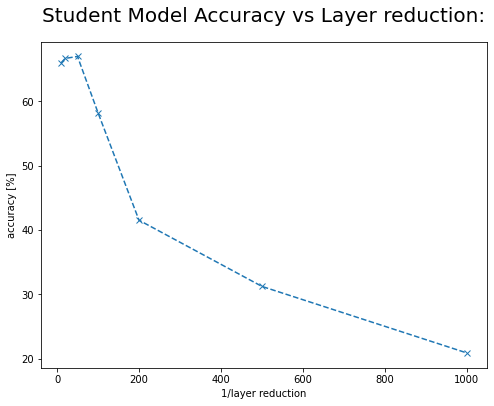

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(np.array(layer_reduction_data)[:,0],
        100*np.array(layer_reduction_data)[:,3],linestyle='--',marker='x')

plt.title('Student Model Accuracy vs Layer reduction:', fontsize=20, pad='20.0')
plt.xlabel('1/layer reduction')
plt.ylabel('accuracy [%]')

plt.show()

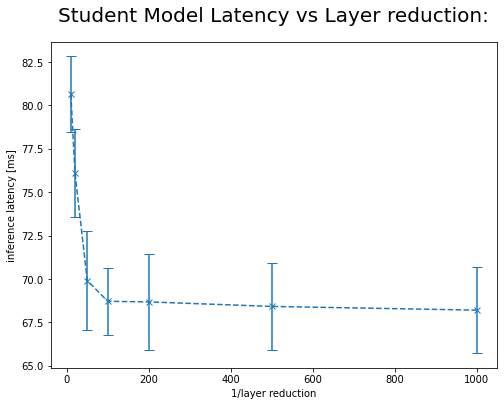

In [ ]:
plt.figure(figsize=(8, 6))

plt.errorbar(np.array(layer_reduction_data)[:,0],
             np.array(layer_reduction_data)[:,1],
             np.array(layer_reduction_data)[:,2],linestyle='--',marker='x',capsize=5)

plt.title('Student Model Latency vs Layer reduction:', fontsize=20, pad='20.0')
plt.xlabel('1/layer reduction')
plt.ylabel('inference latency [ms]')

plt.show()

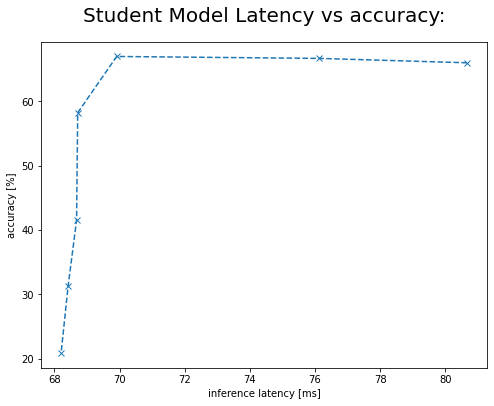

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(np.array(layer_reduction_data)[:,1],
        100*np.array(layer_reduction_data)[:,3],linestyle='--',marker='x')

plt.title('Student Model Latency vs accuracy:', fontsize=20, pad='20.0')
plt.ylabel('accuracy [%]')
plt.xlabel('inference latency [ms]')

plt.show()

**Comments:** We empirically observe a substantial reduction of memory usage of the parameters of the model, linear in the layer reduction factor.

**Comments:** We see that the accuracy remains almost constant up to 1/100 layer reduction, while the latency asymptotes to $\sim$ 68 ms (bottleneck from the convolution layers). In this example, if we pick a reduction factor of 1/50, we are able to reduce latency to roughly $\sim$ 70ms while preserving virtually the same accuracy as in the original "teacher model". Thus, we are outperforming the SVD approach substantially.

The next step would be to check whether a similar reduction of the convolution layers would result in a speedup (without accuracy loss).

####Memory:

In [ ]:
mem=[]
for layer_reduction in [10,20,50,100,200,500,1000]:

  def student_net_fn(batch: Batch) -> jnp.ndarray:
    x = normalize(batch[0])
    
    net = hk.Sequential([
        hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
        jax.nn.relu,
        hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
        hk.Flatten(),
        hk.Linear(3000//layer_reduction), jax.nn.relu,
        hk.Linear(2000//layer_reduction), jax.nn.relu,
        hk.Linear(2000//layer_reduction), jax.nn.relu,
        hk.Linear(1000//layer_reduction), jax.nn.relu,
        hk.Linear(10),
    ])
    return net(x)

  student_net = hk.without_apply_rng(hk.transform(student_net_fn))
  student_params = student_net.init(jax.random.PRNGKey(42), next(train))

  mem_t=sum(p.nbytes for p in jax.tree_util.tree_leaves(params))
  mem_st=sum(p.nbytes for p in jax.tree_util.tree_leaves(student_params))
  mem.append(mem_t/mem_st)
  print(f"Memory space of teacher model: {mem_t}\n"
        f"Memory space of student model ({layer_reduction} reduction factor): {mem_st}\n"
        f"Memory space of teacher/student model: {mem_t/mem_st}\n")

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Memory space of teacher model: 121848904
Memory space of student model (10 reduction factor): 7908904
Memory space of teacher/student model: 15.406547354728291

Memory space of teacher model: 121848904
Memory space of student model (20 reduction factor): 3858904
Memory space of teacher/student model: 31.576039206987268

Memory space of teacher model: 121848904
Memory space of student model (50 reduction factor): 1544104
Memory space of teacher/student model: 78.91236859693389

Memory space of teacher model: 121848904
Memory space of student model (100 reduction factor): 791704
Memory space of teacher/student model: 153.90714711558866

Memory space of teacher model: 121848904
Memory space of student model (200 reduction factor): 419104
Memory space of teacher/student model: 290.7366763380927

Memory space of teacher model: 121848904
Memory space of student model (500 reduction factor): 196696
Memory space of teacher/student model: 619.478301541465

Memory space of teacher model: 1218489

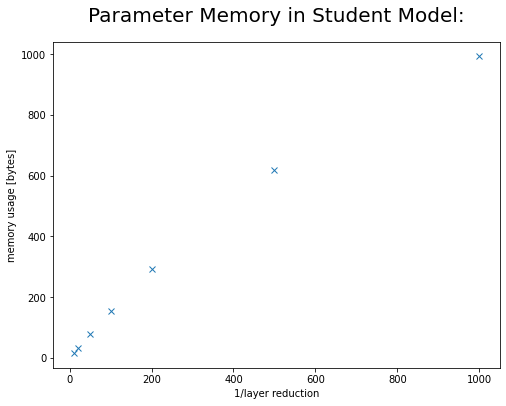

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(np.array([10,20,50,100,200,500,1000]),
             np.array(mem),linestyle='None',marker='x')

plt.title('Parameter Memory in Student Model:', fontsize=20, pad='20.0')
plt.xlabel('1/layer reduction')
plt.ylabel('memory usage [bytes]')

plt.show()

**Comments:** We empirically observe a substantial reduction of memory usage of the parameters of the model, linear in the layer reduction factor.



---



# 4. (linear layers) Pruning
 
I tried some naive form of pruning of the weight matrices. I did not find any speedups in the inference latency, even though the weight matrices become very sparse. I would have to implement sparse matrix multiplication in JAX (I could not find anything suitable online).
 
It is noteworthy that the accuracy barely drops even though we set 99.9% of the weights in the linear layers to zero. So if we can achieve a significant inference speedup this could be promising.


In [61]:
from jax.experimental import sparse

from scipy.sparse import coo_matrix

#from scipy.sparse import dok_array

linear_layers=list(params.keys())[2:]
non_linear_layers=list(params.keys())[:2]

In [12]:
sorted_list_params={}

def pruned_weight(weight, prune_frac,layer):
  if layer in sorted_list_params:
    Wtest_list=sorted_list_params[(layer,wb)]
  else:
    Wtest_list=jnp.sort(abs(weight.reshape(1,-1)))[0]
    #sorted_list_params[(layer,wb)]=Wtest_list
  
  prune_size=jax.device_get(Wtest_list[int(len(Wtest_list)*(1-prune_frac))])
  Wfinal=weight.at[abs(weight)<prune_size].set(0)
  return Wfinal #sparse.BCOO.fromdense(Wfinal)

In [15]:
og_model_mem = sum(p.nbytes for p in jax.tree_util.tree_leaves(params))

In [47]:
prune_truncated_params_coo['linear_1']['w']

<3000x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 600000 stored elements in Compressed Sparse Row format>

In [50]:
mattt=prune_truncated_params_coo['linear_2']['w']

mattt.data.nbytes 

1600000

In [68]:
net = hk.without_apply_rng(hk.transform(net_fn))
test_batch=next(test)

prune_and_times=[]
prune_and_accuracies=[]
prune_and_mem=[]
prune_truncated_params = deepcopy(params)
prune_truncated_params_coo = deepcopy(params)

og_test_accuracy, og_durations = compute_eval_metrics(params,test_batch, 50)
og_duration = np.mean(og_durations)

for prune_frac in [0.1,0.05, 0.01,0.00025]:
  for layer in params.keys():
    if 'conv' in layer:
      continue
    for wb in {'w','b'}:
      weight = params[layer][wb]
      w_prune = pruned_weight(weight, prune_frac, layer)
      prune_truncated_params_coo[layer][wb] = coo_matrix(w_prune).tocsr()
      prune_truncated_params[layer][wb] = w_prune
    
  test_accuracy, duration = compute_eval_metrics(prune_truncated_params,test_batch, 50)

  prune_and_times.append((prune_frac, np.mean(duration), np.std(duration)))
  prune_and_accuracies.append((prune_frac, np.mean(test_accuracy)))

  mem = (sum(p.data.nbytes for p in [prune_truncated_params_coo[l][bw] for l in linear_layers for bw in ['b','w']])+\
        sum(p.nbytes for p in [prune_truncated_params_coo[l][bw] for l in non_linear_layers for bw in ['b','w']]))/float(og_model_mem)
  prune_and_mem.append((prune_frac, mem))

  print(f"Prune Fraction / Test accuracy %: "
          f"{prune_frac:.4f} / {np.mean(test_accuracy)/og_test_accuracy:.4f}.")
  print(f"Prune Fraction / Duration %: "
          f"{prune_frac:.4f} / {np.mean(duration)/og_duration:.4f}.")
  print(f"Prune Fraction / Memory  %: "
          f"{prune_frac:.4f} / {mem:.4f}.")
  print('---------------------------------------------------------------------------')

Prune Fraction / Test accuracy %: 0.1000 / 0.9586.
Prune Fraction / Duration %: 0.1000 / 0.9269.
Prune Fraction / Memory  %: 0.1000 / 0.1004.
---------------------------------------------------------------------------
Prune Fraction / Test accuracy %: 0.0500 / 0.8979.
Prune Fraction / Duration %: 0.0500 / 0.9065.
Prune Fraction / Memory  %: 0.0500 / 0.0504.
---------------------------------------------------------------------------
Prune Fraction / Test accuracy %: 0.0100 / 0.2204.
Prune Fraction / Duration %: 0.0100 / 0.8881.
Prune Fraction / Memory  %: 0.0100 / 0.0104.
---------------------------------------------------------------------------
Prune Fraction / Test accuracy %: 0.0003 / 0.1538.
Prune Fraction / Duration %: 0.0003 / 0.8632.
Prune Fraction / Memory  %: 0.0003 / 0.0007.
---------------------------------------------------------------------------


## Toy example for inference timing:

In [74]:
def trunc_net_fn(batch: Batch) -> jnp.ndarray:
  x = normalize(batch[0])
  
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten()
  ])
  return net(x)

trunc_net = hk.without_apply_rng(hk.transform(trunc_net_fn))

In [ ]:
trunc_params = prune_truncated_params

In [71]:
def relu(x):
  return np.maximum(0, x)

In [92]:
n_samples=1000

out0=coo_matrix(trunc_net.apply(trunc_params, batch)).tocsr()[0]

A0=prune_truncated_params_coo['linear']['w']
b0=prune_truncated_params_coo['linear']['b']
A1=prune_truncated_params_coo['linear_1']['w']
b1=prune_truncated_params_coo['linear_1']['b']
A2=prune_truncated_params_coo['linear_2']['w']
b2=prune_truncated_params_coo['linear_2']['b']
A3=prune_truncated_params_coo['linear_3']['w']
b3=prune_truncated_params_coo['linear_3']['b']
A4=prune_truncated_params_coo['linear_4']['w']
b4=prune_truncated_params_coo['linear_4']['b']

timings=np.zeros((n_samples,))
#warm-up
for _ in range(10):
  _ = (((((out0@A0).maximum(0)@A1+b1).maximum(0)@A2+b2).maximum(0)@A3+b3).maximum(0)@A4+b4).maximum(0)

with torch.no_grad():
  for rep in range(n_samples):
    starter.record()
    _ = (((((out0@A0).maximum(0)@A1+b1).maximum(0)@A2+b2).maximum(0)@A3+b3).maximum(0)@A4+b4).maximum(0)
    ender.record()

    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    timings[rep] = curr_time

print('sparse:', np.mean(timings),np.std(timings))

out0=trunc_net.apply(trunc_params, batch)[0]

A0=params['linear']['w']
b0=params['linear']['b']
A1=params['linear_1']['w']
b1=params['linear_1']['b']
A2=params['linear_2']['w']
b2=params['linear_2']['b']
A3=params['linear_3']['w']
b3=params['linear_3']['b']
A4=params['linear_4']['w']
b4=params['linear_4']['b']

timings=np.zeros((n_samples,))
#warm-up
for _ in range(10):
 _ = relu(relu(relu(relu(relu(out0@A0)@A1+b1)@A2+b2)@A3+b3)@A4+b4)

with torch.no_grad():
  for rep in range(n_samples):
    starter.record()
    _ = relu(relu(relu(relu(relu(out0@A0)@A1+b1)@A2+b2)@A3+b3)@A4+b4)
    ender.record()

    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    timings[rep] = curr_time

print('dense:', np.mean(timings),np.std(timings))

sparse: 2.426904354214668 2.790485601785916
dense: 2.2121717773675917 0.7190216054235828


In [93]:
 @jax.jit
def compute_pruned_net(trunc_params,batch):
  out=coo_matrix(trunc_net.apply(trunc_params, batch)).tocsr()
  outb=coo_matrix(np.ones(out.shape[0]).reshape(-1,1)).tocsr()
  for layer in linear_layers:
    out_temp=out@trunc_params[layer]['w']+outb@trunc_params[layer]['b']
    out=out_temp.maximum(0)

  return out

@jax.jit
def comp_net(params,batch):
  return net.apply(params,batch)

In [104]:
n_samples=1000
trunc_params=prune_truncated_params_coo

batch=next(test)
out0=coo_matrix(trunc_net.apply(trunc_params, batch)).tocsr()[0]
outb=coo_matrix(np.ones(out0.shape[0]).reshape(-1,1)).tocsr()


timings=np.zeros((n_samples,))
#warm-up
for _ in range(10):
  out=out0
  for layer in linear_layers:
    out_temp=out@trunc_params[layer]['w']+outb@trunc_params[layer]['b']
    out=out_temp.maximum(0)


with torch.no_grad():
  for rep in range(n_samples):

    starter.record()

    out=out0
    for layer in linear_layers:
      out_temp=out@trunc_params[layer]['w']+outb@trunc_params[layer]['b']
      out=out_temp.maximum(0)

    ender.record()

    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    timings[rep] = curr_time

print(np.mean(timings),np.std(timings))

2.5749866248369218 1.2885197329827793


In [105]:
n_samples=1000

batch=next(test)
out0=trunc_net.apply(params, batch)[0]
outb=jnp.ones(out0.shape[0]).reshape(-1,1)

timings=np.zeros((n_samples,))
#warm-up
for _ in range(10):

  out=out0
  for layer in linear_layers:
    out_temp=out@params[layer]['w']+params[layer]['b']
    out=relu(out_temp)


with torch.no_grad():
  for rep in range(n_samples):

    starter.record()
    
    out=out0
    for layer in linear_layers:
      out_temp=out@params[layer]['w']+params[layer]['b']
      out=relu(out_temp)

    ender.record()

    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    timings[rep] = curr_time

print(np.mean(timings),np.std(timings))

2.3314254693984986 0.6533769531413954


Continue: 1. implement sparse matrix computation, 2. compare inference timing